In [130]:
import json
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
json_path = "../data/data/IPBLN/json/gesbib_authors_ipbln_info.json"

# Cargar JSON
with open(json_path, encoding="utf-8") as f:
    author_data = json.load(f)

In [132]:
# Crear estructura para almacenar datos
rows = []
for author_id, data in author_data.items():
    materias = defaultdict(int)
    
    # Añadir materias JCR
    for m, v in data.get("materiasJcr", {}).items():
        materias[m.lower().strip()] += v
        
    # Añadir materias CS
    for m, v in data.get("materiasCs", {}).items():
        materias[m.lower().strip()] += v

    # Crear fila
    row = {"author_id": author_id}
    row.update(materias)
    rows.append(row)

# Crear DataFrame
df = pd.DataFrame(rows)
df = df.fillna(0)  # reemplazar NaNs con 0

In [48]:
# Mostrar resumen
print(f"Autores: {df.shape[0]} | Materias distintas: {df.shape[1] - 1}")
df.head()

Autores: 724 | Materias distintas: 335


,author_id,"chemistry, organic","chemistry, medicinal","chemistry, multidisciplinary",materials chemistry,molecular biology,pharmaceutical science,general medicine,clinical biochemistry,metals and alloys,...,regional & urban planning,"management, monitoring, policy and law",nature and landscape conservation,nuclear science & technology,radiation,otorhinolaryngology,"medicine, legal",mathematical physics,small animals,urban studies
0,2078,3.0,2.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2105,3.0,0.0,6.0,2.0,2.0,5.0,7.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4243,1.0,0.0,1.0,0.0,29.0,1.0,38.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4244,7.0,4.0,4.0,0.0,34.0,3.0,67.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13157,6.0,6.0,82.0,50.0,4.0,11.0,28.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

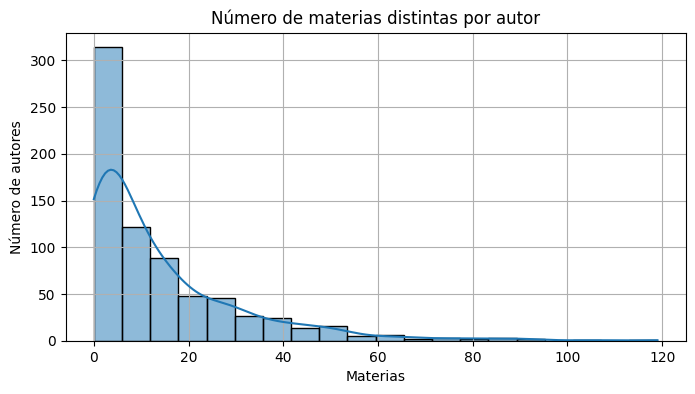

In [49]:
# Eliminar la columna author_id para análisis numérico
df_materias = df.drop(columns=["author_id"])

# 1. Distribución del número de materias distintas por autor
materias_por_autor = (df_materias > 0).sum(axis=1)
plt.figure(figsize=(8, 4))
sns.histplot(materias_por_autor, bins=20, kde=True)
plt.title("Número de materias distintas por autor")
plt.xlabel("Materias")
plt.ylabel("Número de autores")
plt.grid(True)
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_7988\527380277.py:8: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


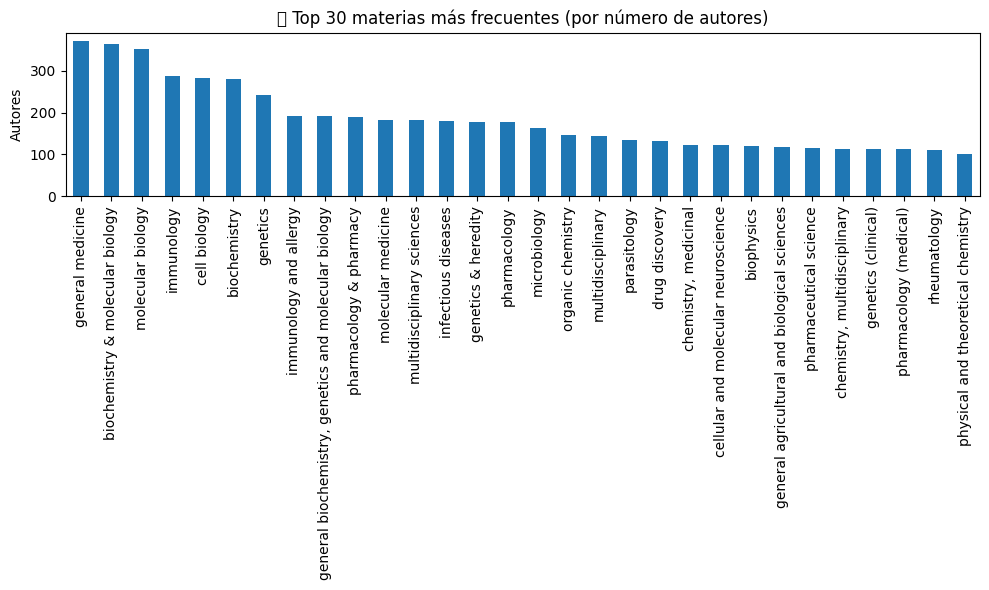

In [50]:
# 2. Materias más frecuentes (por número de autores que la tienen)
materia_freq = (df_materias > 0).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
materia_freq.head(30).plot(kind="bar")
plt.title("🔝 Top 30 materias más frecuentes (por número de autores)")
plt.ylabel("Autores")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_7988\3648265781.py:8: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


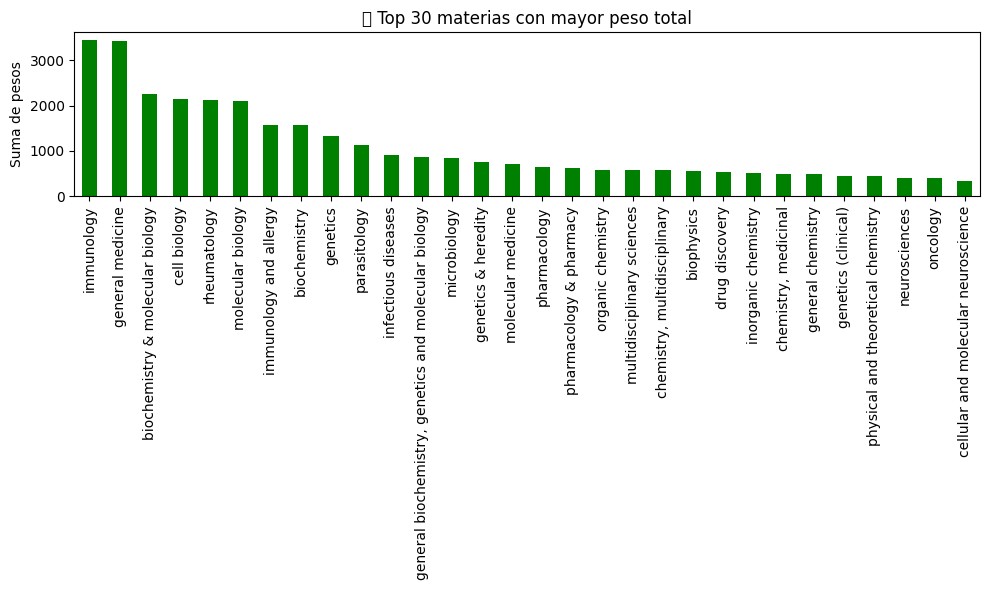

In [51]:
# 3. Distribución de pesos totales por materia
materia_pesos = df_materias.sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
materia_pesos.head(30).plot(kind="bar", color='green')
plt.title("🔝 Top 30 materias con mayor peso total")
plt.ylabel("Suma de pesos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

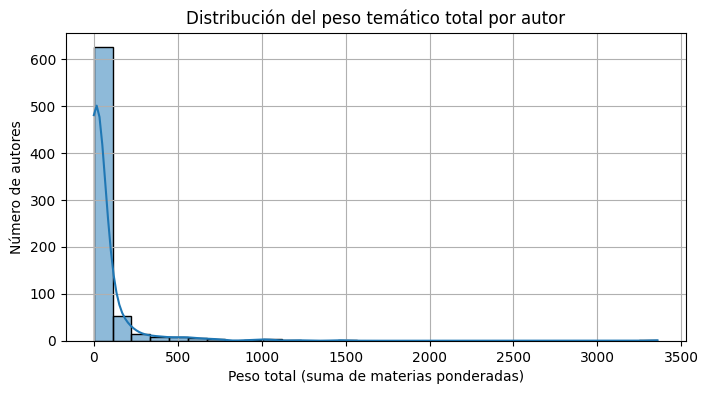

In [52]:
# 4. Autores con mayor carga temática (más peso total)
autores_pesos = df_materias.sum(axis=1)
plt.figure(figsize=(8, 4))
sns.histplot(autores_pesos, bins=30, kde=True)
plt.title("Distribución del peso temático total por autor")
plt.xlabel("Peso total (suma de materias ponderadas)")
plt.ylabel("Número de autores")
plt.grid(True)
plt.show()

c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


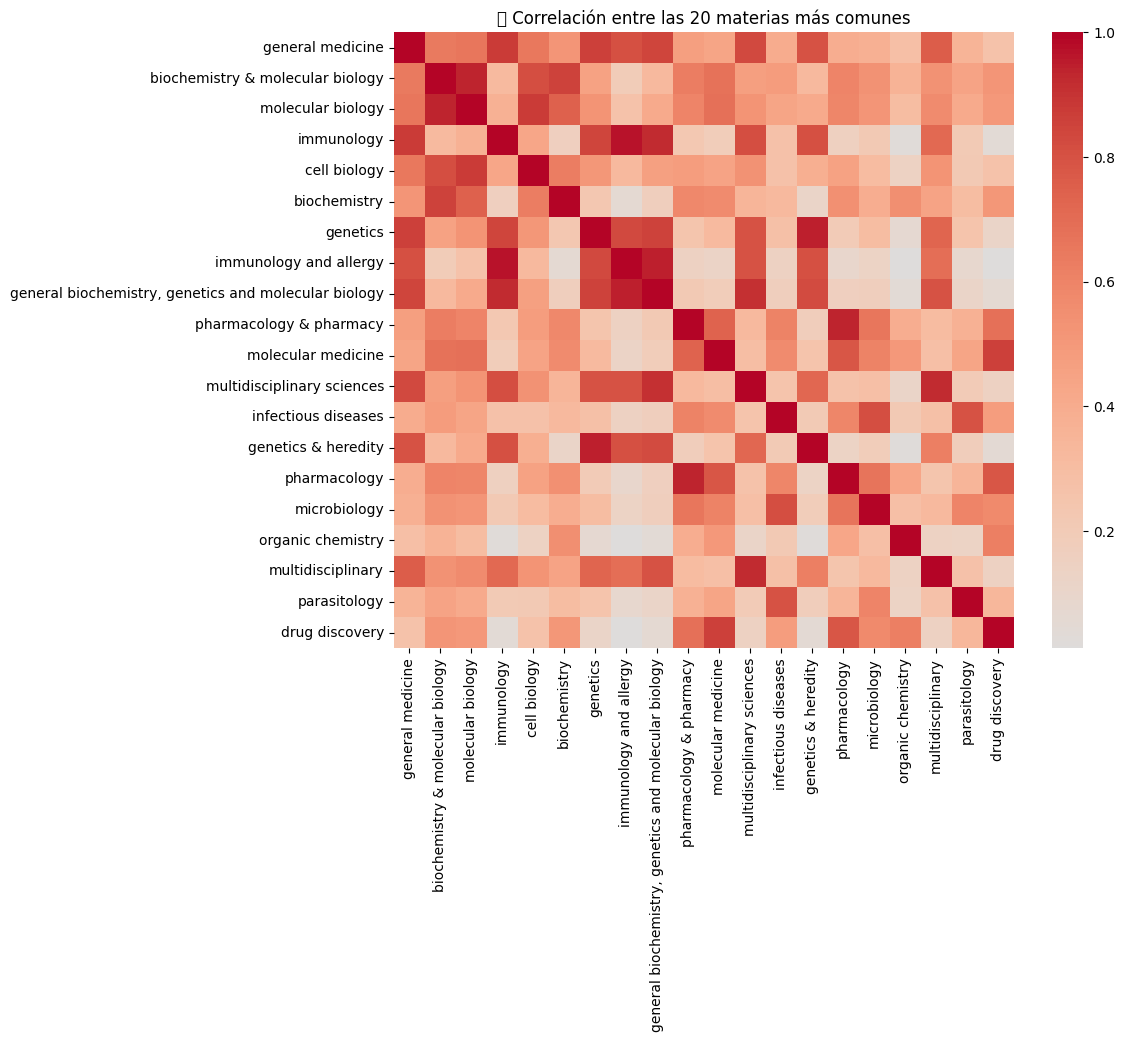

In [53]:
# 5. Mapa de calor de correlaciones entre materias más frecuentes
top_materias = materia_freq.head(20).index
corr_matrix = df_materias[top_materias].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("🔁 Correlación entre las 20 materias más comunes")
plt.show()

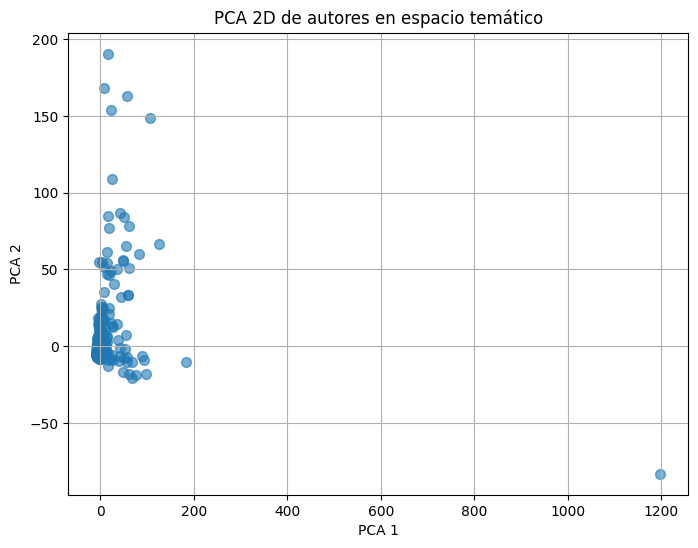

In [54]:
# 6. Proyección con PCA a 2D para ver distribución de autores
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_proj = pca.fit_transform(df_materias)
plt.figure(figsize=(8, 6))
plt.scatter(df_proj[:, 0], df_proj[:, 1], alpha=0.6, s=50)
plt.title("PCA 2D de autores en espacio temático")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

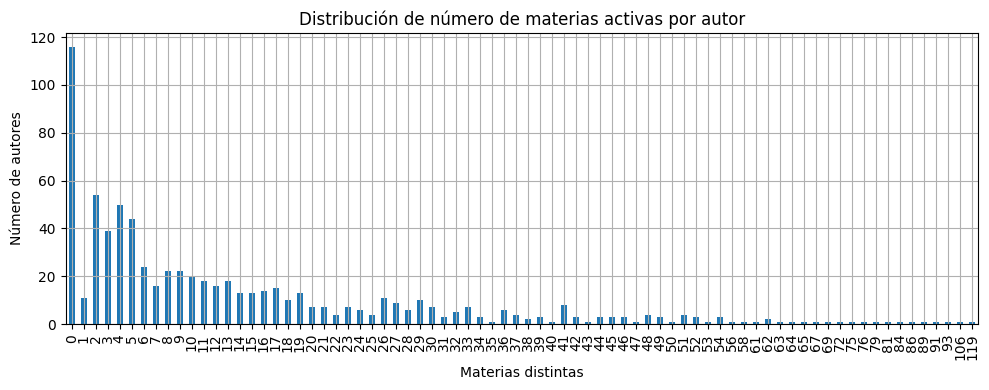

In [55]:
# 7. Proporción de autores por número de materias
materias_por_autor.value_counts().sort_index().plot(kind='bar', figsize=(10, 4))
plt.title("Distribución de número de materias activas por autor")
plt.xlabel("Materias distintas")
plt.ylabel("Número de autores")
plt.grid(True)
plt.tight_layout()
plt.show()

## Preprocesamiento

In [133]:
# Separar materias
df_materias = df.drop(columns=["author_id"])

# Filtrar columnas con al menos un valor distinto de cero
df_materias = df_materias.loc[:, (df_materias != 0).any(axis=0)]

# Reconstruir el DataFrame completo
df_cleaned = pd.concat([df["author_id"], df_materias], axis=1)

print(f"👉 Columnas antes: {df.shape[1]} | Después de limpieza: {df_cleaned.shape[1]}")

👉 Columnas antes: 336 | Después de limpieza: 336


In [134]:
all_subjects = df_materias.columns.tolist()
print(f"{all_subjects}")

['chemistry, organic', 'chemistry, medicinal', 'chemistry, multidisciplinary', 'materials chemistry', 'molecular biology', 'pharmaceutical science', 'general medicine', 'clinical biochemistry', 'metals and alloys', 'pharmacology', 'biochemistry', 'ceramics and composites', 'drug discovery', 'general chemistry', 'electronic, optical and magnetic materials', 'surfaces, coatings and films', 'molecular medicine', 'catalysis', 'organic chemistry', 'neurosciences', 'materials science, biomaterials', 'chemistry, analytical', 'biotechnology & applied microbiology', 'polymer science', 'medicine, research & experimental', 'virology', 'biochemistry & molecular biology', 'immunology', 'nanoscience & nanotechnology', 'biochemical research methods', 'pharmacology & pharmacy', 'infectious diseases', 'multidisciplinary sciences', 'bioengineering', 'biotechnology', 'biomaterials', 'biomedical engineering', 'general neuroscience', 'microbiology (medical)', 'cellular and molecular neuroscience', 'polymer

In [135]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios (solo la primera vez)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords estándar + personalizadas
stop_words = set(stopwords.words('english')).union({
    "general", "miscellaneous", "misc", "applied", "special", "multidisciplinary",
    "science", "sciences", "studies", "engineering", "technology", "systems",
    "methods", "interdisciplinary", "other", "clinical", "medical"
})

# Lematizador
lemmatizer = WordNetLemmatizer()

def clean_subject_nltk(subject):
    subject = subject.lower()
    subject = re.sub(r"[^\w\s]", " ", subject)
    tokens = nltk.word_tokenize(subject)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [137]:
# Aplicación al listado completo
cleaned_subjects = [clean_subject_nltk(s) for s in all_subjects]

# Ejemplo de comparación
for original, cleaned in zip(all_subjects[:10], cleaned_subjects[:10]):
    print(f"- {original} → {cleaned}")

cleaned_subjects = list(set(cleaned_subjects))
print(f"Materias originales: {len(all_subjects)} | Materias limpias: {len(cleaned_subjects)}")

- chemistry, organic → chemistry organic
- chemistry, medicinal → chemistry medicinal
- chemistry, multidisciplinary → chemistry
- materials chemistry → material chemistry
- molecular biology → molecular biology
- pharmaceutical science → pharmaceutical
- general medicine → medicine
- clinical biochemistry → biochemistry
- metals and alloys → metal alloy
- pharmacology → pharmacology
Materias originales: 335 | Materias limpias: 280


## Modelo

In [93]:
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_distances

In [94]:
# === VECTORIZACIÓN DE MATERIAS CON BERT ===
print("🔎 Vectorizando materias con BERT...")
model = SentenceTransformer("all-MiniLM-L6-v2")
subject_vectors = model.encode(cleaned_subjects)

print(f"🔍 Autores: {df_materias.shape[0]} | Materias activas: {len(cleaned_subjects)}")

🔎 Vectorizando materias con BERT...
🔍 Autores: 724 | Materias activas: 335


Reducción de dimensionalidad

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30, random_state=42)
reduced_vectors = pca.fit_transform(subject_vectors)

### KMeans

In [106]:
# === EXPERIMENTACIÓN CON CLUSTERING ===
results = []
cluster_range = range(2, 51)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_vectors)
    labels = kmeans.labels_
    sil = silhouette_score(reduced_vectors, labels)
    ch = calinski_harabasz_score(reduced_vectors, labels)
    results.append({
        "k": k,
        "model": kmeans,
        "labels": labels,
        "silhouette": sil,
        "calinski": ch
    })

In [107]:
# Mostrar resultados
df_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False)
best_k = df_results.iloc[0]["k"]
best_labels = df_results.iloc[0]["labels"]
best_model = df_results.iloc[0]["model"]
print(f"\n✅ Mejor k: {best_k} | Silhouette: {df_results.iloc[0]['silhouette']:.3f} | Calinski: {df_results.iloc[0]['calinski']:.2f}")


✅ Mejor k: 50 | Silhouette: 0.232 | Calinski: 13.29


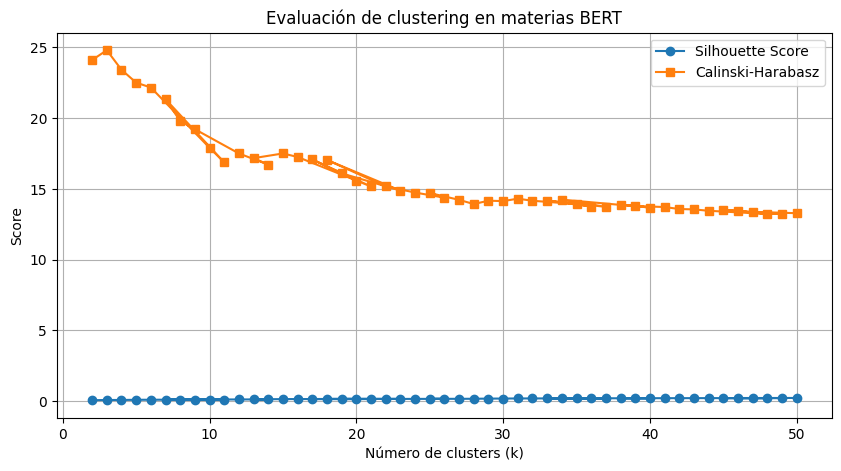

In [108]:
plt.figure(figsize=(10,5))
plt.plot(df_results["k"], df_results["silhouette"], marker='o', label="Silhouette Score")
plt.plot(df_results["k"], df_results["calinski"], marker='s', label="Calinski-Harabasz")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Score")
plt.legend()
plt.title("Evaluación de clustering en materias BERT")
plt.grid(True)
plt.show()

### Agglomerative Clustering


✅ Agglomerative: Mejor k = 50, Silhouette = 0.368, Calinski = 12.89


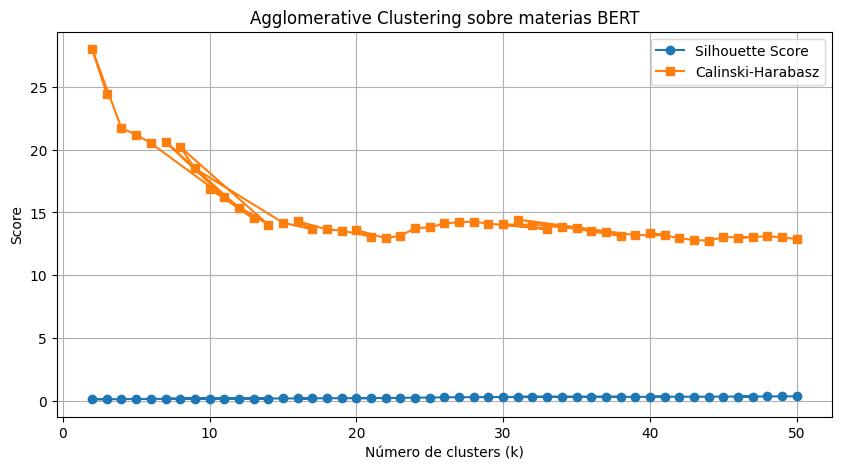

In [109]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd
import matplotlib.pyplot as plt

results_agglo = []
for k in range(2, 51):
    model = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='average')
    labels = model.fit_predict(reduced_vectors)
    sil = silhouette_score(reduced_vectors, labels, metric='cosine')
    ch = calinski_harabasz_score(reduced_vectors, labels)
    results_agglo.append({
        "k": k,
        "model": model,
        "labels": labels,
        "silhouette": sil,
        "calinski": ch
    })

df_agglo = pd.DataFrame(results_agglo).sort_values(by="silhouette", ascending=False)
best_k = df_agglo.iloc[0]["k"]
print(f"\n✅ Agglomerative: Mejor k = {best_k}, Silhouette = {df_agglo.iloc[0]['silhouette']:.3f}, Calinski = {df_agglo.iloc[0]['calinski']:.2f}")

plt.figure(figsize=(10,5))
plt.plot(df_agglo["k"], df_agglo["silhouette"], marker='o', label="Silhouette Score")
plt.plot(df_agglo["k"], df_agglo["calinski"], marker='s', label="Calinski-Harabasz")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Score")
plt.legend()
plt.title("Agglomerative Clustering sobre materias BERT")
plt.grid(True)
plt.show()

### DBSCAN

In [110]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=3, metric="cosine")
labels = dbscan.fit_predict(reduced_vectors)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

if n_clusters > 1:
    silhouette = silhouette_score(reduced_vectors, labels, metric='cosine')
    calinski = calinski_harabasz_score(reduced_vectors, labels)
else:
    silhouette = None
    calinski = None

print(f"\n✅ DBSCAN: Clusters = {n_clusters}, Noise = {n_noise}, Silhouette = {silhouette}, Calinski = {calinski}")


✅ DBSCAN: Clusters = 1, Noise = 0, Silhouette = None, Calinski = None


### HDBSCAN

In [119]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = hdb.fit_predict(reduced_vectors)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

if n_clusters > 1:
    silhouette = silhouette_score(reduced_vectors, labels)
    calinski = calinski_harabasz_score(reduced_vectors, labels)
else:
    silhouette = None
    calinski = None

print(f"\n✅ HDBSCAN: Clusters = {n_clusters}, Noise = {n_noise}, Silhouette = {silhouette}, Calinski = {calinski}")



✅ HDBSCAN: Clusters = 7, Noise = 268, Silhouette = -0.039553504437208176, Calinski = 5.186739179313813


c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Optimización de hiperparámetros en HDBSCAN

In [129]:
from itertools import product

# === RANGO DE HIPERPARÁMETROS A EVALUAR ===
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
reduced_vectors = pca.fit_transform(subject_vectors)

min_cluster_sizes = list(range(5, 51))
min_samples_list = list(range(1, 11))
metrics = ['euclidean', 'manhattan']
cluster_selection_methods = ['leaf', 'eom']

results = []

# === EXPLORACIÓN DE COMBINACIONES ===
for min_cluster_size, min_samples, metric, cluster_selection_method in product(min_cluster_sizes, min_samples_list, metrics, cluster_selection_methods):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        prediction_data=True,
        cluster_selection_method=cluster_selection_method,
    )
    labels = clusterer.fit_predict(reduced_vectors)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = sum(labels == -1)

    # Ignorar si solo hay 1 cluster (sin sentido para Silhouette)
    if n_clusters <= 1:
        continue

    try:
        sil_score = silhouette_score(reduced_vectors, labels)
        ch_score = calinski_harabasz_score(reduced_vectors, labels)
    except:
        sil_score = None
        ch_score = None

    results.append({
        "min_cluster_size": min_cluster_size,
        "min_samples": min_samples,
        "metric": metric,
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "cluster_selection_method": cluster_selection_method,
        "silhouette": sil_score,
        "calinski": ch_score
    })

# === RESULTADOS ORDENADOS ===
df_hdbscan_results = pd.DataFrame(results)
df_hdbscan_results = df_hdbscan_results.sort_values(by="silhouette", ascending=False).reset_index(drop=True)
print(df_hdbscan_results.head())

# === VISUALIZACIÓN DE LA MEJOR CONFIGURACIÓN ===
best_config = df_hdbscan_results.iloc[0]
print(f"\n✅ Mejor configuración HDBSCAN:\n{best_config}")

c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

   min_cluster_size  min_samples     metric  n_clusters  n_noise  \
0                 5            1  euclidean          17      158   
1                 5            1  euclidean          17      158   
2                 5            2  euclidean          15      182   
3                 5            2  euclidean          15      182   
4                 6            1  euclidean          13      173   

  cluster_selection_method  silhouette  calinski  
0                     leaf    0.053525  6.535577  
1                      eom    0.053525  6.535577  
2                     leaf    0.047546  6.755031  
3                      eom    0.047546  6.755031  
4                      eom    0.031694  6.847725  

✅ Mejor configuración HDBSCAN:
min_cluster_size                    5
min_samples                         1
metric                      euclidean
n_clusters                         17
n_noise                           158
cluster_selection_method         leaf
silhouette               

c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Pablo\OneDrive\Documentos\Estudios\DATCOM\Trabajo Fin de Máster\App\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

## Guardar mejor resultado

In [65]:
# === ASIGNAR TEMAS A MATERIAS ===
subject_to_topic = {
    subject: f"Topic_{label}"
    for subject, label in zip(all_subjects, best_labels)
}

In [66]:
# === ETIQUETA REPRESENTATIVA DE CADA TEMA ===
topic_labels = defaultdict(list)
for subj, label in zip(all_subjects, best_labels):
    topic_labels[label].append(subj)

topic_representative = {}
for label, subjects in topic_labels.items():
    idxs = [all_subjects.index(s) for s in subjects]
    vectors = subject_vectors[idxs]
    center = best_model.cluster_centers_[label].reshape(1, -1)
    dists = cosine_distances(vectors, center).flatten()
    rep = subjects[np.argmin(dists)]
    topic_representative[f"Topic_{label}"] = rep.title()

In [67]:
# Mostrar resumen
for topic, subs in topic_labels.items():
    print(f"\n🧠 Topic_{topic} ({len(subs)} materias):")
    print("→ Representa:", topic_representative[f"Topic_{topic}"])
    print(", ".join(subs[:10]), "...")


🧠 Topic_21 (7 materias):
→ Representa: Environmental Chemistry
chemistry, organic, organic chemistry, environmental sciences, pollution, environmental chemistry, general environmental science, environmental science (miscellaneous) ...

🧠 Topic_6 (10 materias):
→ Representa: Pharmacology
chemistry, medicinal, pharmaceutical science, pharmacology, drug discovery, molecular medicine, pharmacology & pharmacy, pharmacology (medical), toxicology, health, toxicology and mutagenesis, general pharmacology, toxicology and pharmaceutics ...

🧠 Topic_10 (8 materias):
→ Representa: Multidisciplinary
chemistry, multidisciplinary, multidisciplinary sciences, multidisciplinary, materials science, multidisciplinary, engineering, multidisciplinary, geosciences, multidisciplinary, psychology, multidisciplinary, physics, multidisciplinary ...

🧠 Topic_41 (16 materias):
→ Representa: Materials Chemistry
materials chemistry, metals and alloys, ceramics and composites, general chemistry, electronic, optical

In [68]:
# === ASIGNAR TEMA A CADA AUTOR ===
author_topic = {}
for _, row in df.iterrows():
    aid = row["author_id"]
    counter = Counter()
    for subj, val in row.drop("author_id").items():
        topic = subject_to_topic.get(subj)
        if topic and val > 0:
            counter[topic] += val
    author_topic[aid] = counter.most_common(1)[0][0] if counter else "Unknown"

In [69]:
# === CONSTRUIR DATAFRAME FINAL ===
df_topics = pd.DataFrame([
    {"author_id": aid, "main_topic": topic, "main_topic_label": topic_representative.get(topic, topic)}
    for aid, topic in author_topic.items()
])
df_topics.to_csv("../data/data/IPBLN/csv/author_topics_optimized.csv", index=False)
print("\n📁 Archivo guardado en 'author_topics_optimized.csv'")


📁 Archivo guardado en 'author_topics_optimized.csv'
